In [3]:
import numpy as np
import sys
import copy
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Gillespie_backend/')
import Gillespie_backend as Gil
import matplotlib.pyplot as plt
import tqdm
from multiprocessing import Pool
%matplotlib inline
plt.rcParams["figure.figsize"] = (4,3)

# Summarize
Here, we compute the rate of binding/unbinding/diffusive moves, for various values of N and ell_tot. Starting with $k_{diff} = 1/\tau_0$. Let us start by confirming that the binding energy has no effect on the rate of diffusive moves as soon as the binding energy is sufficiently low (negative).
## binding energy

In [15]:
bins = np.array([0, 1, 2, 3, 4])
def calculate_percentages(array):
    # Create bins for 0, 1, 2, 3, and an extra bin for the upper edge 
    # Use histogram to count the occurrences
    counts, _ = np.histogram(array, bins=bins)
    # Calculate percentages
    percentages = (counts / array.size) * 100
    return dict(zip(range(4), percentages))
def compute_percent_moves(gillespie,steps):
    move,time = gillespie.evolve(steps)
    return calculate_percentages(move)

In [ ]:
#default values:
step_tot = 10000
ell_tot = 1000.
N = 10
BindingEnergy = -10.

In [22]:
Npoints = 20
percent_diff = np.zeros(Npoints,dtype=float)
percent_bind = np.zeros_like(percent_diff)
percent_unbind = np.zeros_like(percent_diff)
for n,binding_energy in enumerate(np.linspace(-10,5,Npoints)):
    S = Gil.Gillespie(ell_tot,Nlinker=N,BindingEnergy=binding_energy,kdiff=1,seed=19880,sliding=False)    
    percent = compute_percent_moves(S,step_tot)
    percent_diff[n] =percent[1]
    percent_bind[n] = percent[3]
    percent_unbind[n] = percent[0]

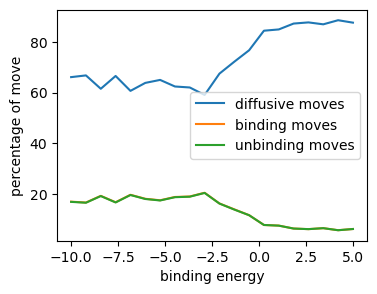

In [23]:
plt.plot(np.linspace(-10,5,Npoints),percent_diff,label="diffusive moves")
plt.plot(np.linspace(-10,5,Npoints),percent_bind,label='binding moves')
plt.plot(np.linspace(-10,5,Npoints),percent_unbind,label='unbinding moves')
plt.xlabel('binding energy')
plt.ylabel('percentage of move')
plt.legend()

## linkers

In [76]:
Nlinker_list = [1,2,3,4,5,10,15,20,30,40,50,75,100,150]
Npoints = Nlinker_list.__len__()
percent_diff = np.zeros(Npoints,dtype=float)
percent_bind = np.zeros_like(percent_diff)
percent_unbind = np.zeros_like(percent_diff)
for n,Nlinker in enumerate(Nlinker_list):
    S = Gil.Gillespie(ell_tot,Nlinker=Nlinker,BindingEnergy=BindingEnergy,kdiff=1,seed=19880,sliding=False)    
    percent = compute_percent_moves(S,step_tot)
    percent_diff[n] =percent[1]
    percent_bind[n] = percent[3]
    percent_unbind[n] = percent[0]

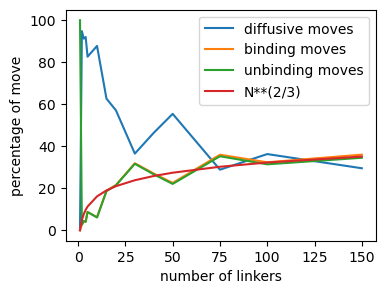

In [82]:
plt.plot(Nlinker_list,percent_diff,label="diffusive moves")
plt.plot(Nlinker_list,percent_bind,label='binding moves')
plt.plot(Nlinker_list,percent_unbind,label='unbinding moves')
plt.xlabel('number of linkers')
plt.ylabel('percentage of move')
#plt.yscale('log')
#plt.xscale('log')
#plt.plot(Nlinker_list,[4*Nlinker**0.666 for Nlinker in Nlinker_list],label='N**(2/3)')
plt.plot(Nlinker_list,[7*np.log(Nlinker) for Nlinker in Nlinker_list],label='N**(2/3)')
plt.legend()

## polymer length

In [84]:
length_list = [100,150,200,250,300,400,500,750,1000,1500,2000,3000,4000,5000,7000,10000]
Npoints = length_list.__len__()
percent_diff = np.zeros(Npoints,dtype=float)
percent_bind = np.zeros_like(percent_diff)
percent_unbind = np.zeros_like(percent_diff)
for n,ell_tot in enumerate(length_list):
    S = Gil.Gillespie(ell_tot,Nlinker=10,BindingEnergy=-10,kdiff=1,seed=199870,sliding=False)    
    percent = compute_percent_moves(S,step_tot)
    percent_diff[n] =percent[1]
    percent_bind[n] = percent[3]
    percent_unbind[n] = percent[0]

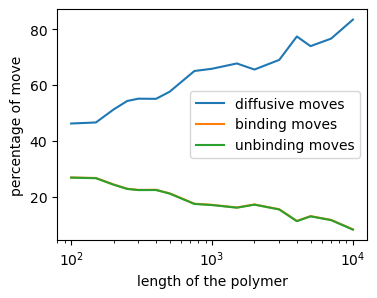

In [86]:
plt.plot(length_list,percent_diff,label="diffusive moves")
plt.plot(length_list,percent_bind,label='binding moves')
plt.plot(length_list,percent_unbind,label='unbinding moves')
plt.xlabel('length of the polymer')
plt.ylabel('percentage of move')
#plt.yscale('log')
plt.xscale('log')
#plt.plot(length_list,[100*length**-0.25 for length in length_list])
plt.legend()

# Old

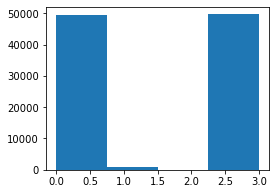

In [5]:
count,bin,graph = plt.hist(bind,bins=4)
#plt.xticks([0,1,2,3],['unbind','diffuse_linker','slide','bind'])
#plt.show()

In [6]:
percent_diff_moves = count[1]/step_tot

In [7]:
def diff_moves_loop(rho,ell,E):
    S = Gillespie(ell,rho,E,kdiff=np.exp(E),seed=19880,sliding=False)
    Nloops = np.zeros(step_tot,dtype=int)
    bind = np.zeros(step_tot,dtype=int)
    for step in range(step_tot):
        bind[step],time = S.evolve(steps=1)
        Nloops[step] = S.get_N_loop()
    count,bin,graph = plt.hist(bind,bins=4)
    return count[1]/step_tot,count[0]/step_tot,sum(Nloops)/step_tot

In [9]:
rhomin,rhomax,Npoints = 10**-4,10**-2,100
Nreplica = 12


#for replica in range(Nreplica):
with Pool(10) as p:
    count_N_av = p.starmap(diff_moves_loop,zip(np.linspace(rhomin,rhomax,Npoints),
                            np.array([100 for _ in range(Npoints)]),
                            np.array([-10 for _ in range(Npoints)])))

In [10]:
count_N_av = np.array(count_N_av)
print(count_N_av[0])

[0.20567 0.39716 2.80389]


Text(0, 0.5, 'N_strands')

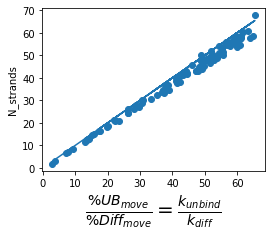

In [17]:
plt.scatter(count_N_av[:,2],count_N_av[:,1]/(count_N_av[:,0]))
plt.plot(count_N_av[:,2],count_N_av[:,2])
plt.xlabel(r'$\frac{\% UB_{move}}{\%Diff_{move}} = \frac{k_{unbind}}{k_{diff}}$',fontsize=20)
plt.ylabel('N_strands')

This graph shows that $k_\text{diff} = N_\text{strands}k_\text{unbind}$